# Encoding data

In general, SciKit learn only processes numerical data (with some rare exceptions).  Therefore it's necessary to encode categorical data prior to the application of any of the ML algorithms from sklearn.  However, there are several considerations that will impact your data processing.

#### Label Encoding: When Not to Use It

Label encoding transforms categorical data into integer values (e.g., 'red' -> 0, 'blue' -> 1, 'green' -> 2). While this is convenient, it's not suitable for non-ordinal categorical variables (variables that don't have a natural order) when using certain algorithms like Logistic Regression.  Note that label encoding is generally ok for Decision Trees (we'll talk about these later).

##### Example: Why LabelEncoding Messes Up ML

Consider a synthetic dataset with two clear clusters:


C:\Users\Dr Issah\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dr Issah\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


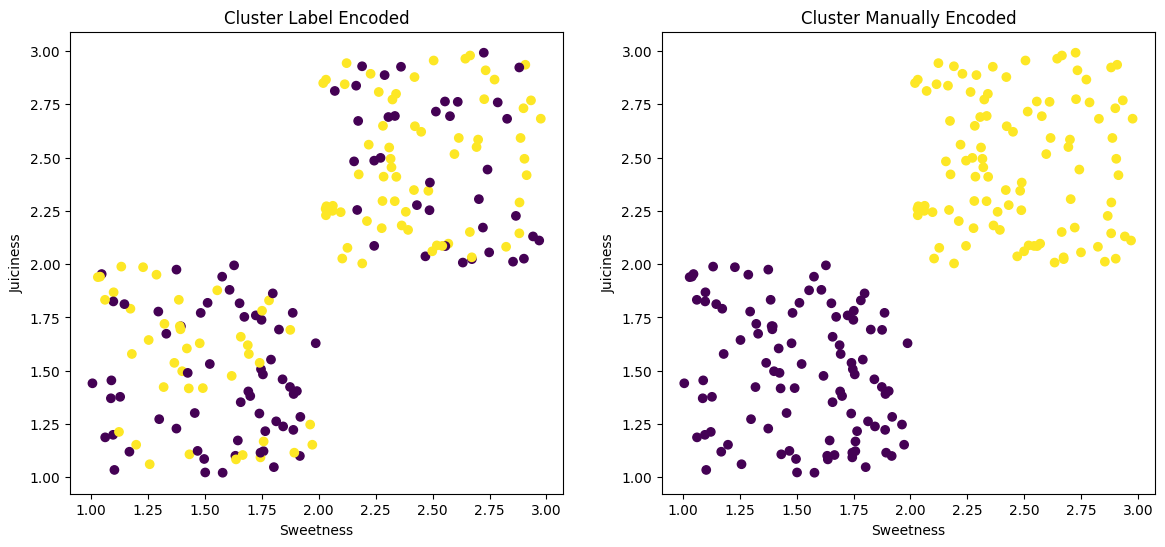

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Generate synthetic data
n_samples = 100
sweet_juicy = np.random.uniform(2, 3, (n_samples, 2))
not_sweet_not_juicy = np.random.uniform(1, 2, (n_samples, 2))

# Assign colors (ordinal labels should coincide with the natural clusters)
colors_sweet_juicy = np.random.choice(['Blue', 'Orange', 'Purple'], n_samples)
colors_not_sweet_not_juicy = np.random.choice(['Green', 'Pink', 'Red'], n_samples)

# Combine data
X = np.vstack([sweet_juicy, not_sweet_not_juicy])
colors = np.concatenate([colors_sweet_juicy, colors_not_sweet_not_juicy])

# Create DataFrame
df = pd.DataFrame(X, columns=['Sweetness', 'Juiciness'])
df['Color'] = colors

# Label encode (alphabetic)
le1 = LabelEncoder()
df['Color_auto_encoded'] = le1.fit_transform(df['Color'])
# Label encode (manual)
color_mapping = {'Blue': 0, 'Orange': 1, 'Purple': 2, 'Green': 3, 'Pink': 4, 'Red': 5}
df['Color_manual_encoded'] = df['Color'].map(color_mapping)

# Perform k-means clustering with auto-encoded labels
kmeans_auto = KMeans(n_clusters=2, random_state=0)
df['Cluster_auto_encoded'] = kmeans_auto.fit_predict(df[['Sweetness', 'Juiciness','Color_auto_encoded']])

# Perform k-means clustering with manually assigned labels
kmeans_manual = KMeans(n_clusters=2, random_state=0)
df['Cluster_manual_encoded'] = kmeans_manual.fit_predict(df[['Sweetness', 'Juiciness','Color_manual_encoded']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(df['Sweetness'], df['Juiciness'], c=df['Cluster_auto_encoded'], cmap='viridis')
axes[0].set_title('Cluster Label Encoded')
axes[0].set_xlabel('Sweetness')
axes[0].set_ylabel('Juiciness')

axes[1].scatter(df['Sweetness'], df['Juiciness'], c=df['Cluster_manual_encoded'], cmap='viridis')
axes[1].set_title('Cluster Manually Encoded')
axes[1].set_xlabel('Sweetness')
axes[1].set_ylabel('Juiciness')

plt.show()






Here, the auto-encoding assigns values in alphabetic order, which conflicts with the natural clustering in the other dimensions.  Reassigning the encoding differently leads to a different result, even though the data didn't change.



#### One-Hot Encoding: A Better Alternative

For non-ordinal categorical variables, it's usually better to use one-hot encoding. This creates a binary column for each category and indicates the presence of the categories with a 1 or 0.  For example:

##### Table with Categorical Column

| Index | Color  |
|-------|--------|
| 0     | Red    |
| 1     | Blue   |
| 2     | Green  |
| 3     | Red    |
| 4     | Green  |

##### Table after One-Hot Encoding

| Index | Color_Red | Color_Blue | Color_Green |
|-------|-----------|------------|-------------|
| 0     | 1         | 0          | 0           |
| 1     | 0         | 1          | 0           |
| 2     | 0         | 0          | 1           |
| 3     | 1         | 0          | 0           |
| 4     | 0         | 0          | 1           |

However, when one-hot encoding, you'll note that if you know two of the columns, you automatically know the value of the third.  This is sometimes referred to as the "dummy variable trap," and creates something called "multicolinearity," which cause problems for learners (like linear regression).  Therefore, it is usually the case that one of the columns is dropped, like:

##### Table after One-Hot Encoding with `Color_Red` dropped.

| Index | Color_Blue | Color_Green |
|-------|------------|-------------|
| 0     | 0          | 0           |
| 1     | 1          | 0           |
| 2     | 0          | 1           |
| 3     | 0          | 0           |
| 4     | 0          | 1           |

Both `pd.get_dummies()` and Scikit-Learn's `OneHotEncoder` serve the same fundamental purpose: they convert categorical data into a format that can be provided to machine learning algorithms, typically in the form of one-hot encoding. However, they do have differences, and each comes with its own set of advantages and disadvantages.

#### Flexibility with Data Types:

- `pd.get_dummies()`: Handles string labels directly.
- `OneHotEncoder`: Only handles string labels if you set `handle_unknown='ignore'`.

#### Handling Unknown Categories:

- `pd.get_dummies()`: Doesn't handle unknown categories in the test data by default. You have to manage this manually.
- `OneHotEncoder`: Can handle unknown categories in test data by setting `handle_unknown='ignore'`.

#### Output Type:

- `pd.get_dummies()`: Returns a DataFrame.
- `OneHotEncoder`: Returns a NumPy array or sparse matrix.

#### Feature Names:

- `pd.get_dummies()`: Directly gives a DataFrame with meaningful column names.
- `OneHotEncoder`: Feature names can be retrieved, but it's not as straightforward as with `get_dummies()`.

#### Imputation:

- `pd.get_dummies()`: Doesn't support missing values.
- `OneHotEncoder`: Doesn't support missing values either, but can work alongside Scikit-Learn's imputation tools, as it is part of the same ecosystem.

#### Pipeline:

- `pd.get_dummies()`: Can't be included in a Scikit-Learn `Pipeline`.
- `OneHotEncoder`: Can be part of a Scikit-Learn `Pipeline`, making it more convenient for model selection and tuning.

### Which is Preferred and Why?

- **For Quick Exploration or Prototyping**: `pd.get_dummies()` is often quicker and easier to use for one-off tasks. 
- **For Production or Pipelined Tasks**: `OneHotEncoder` is usually the choice when building end-to-end machine learning pipelines or when you need better handling of edge cases, like unknown categories in test data.

So, the "best" method depends on the specifics of what you're trying to accomplish. If you're working solely within the Pandas ecosystem for a quick data analysis, `pd.get_dummies()` might be all you need. But if you're developing a machine learning pipeline that will go into production, or if you want more control over the behavior of the encoder, then Scikit-Learn's `OneHotEncoder` is generally more suitable.  In this class, we'll focus on using sci-kit learn's OneHotEncoder.


### Example

C:\Users\Dr Issah\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Dr Issah\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Dr Issah\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


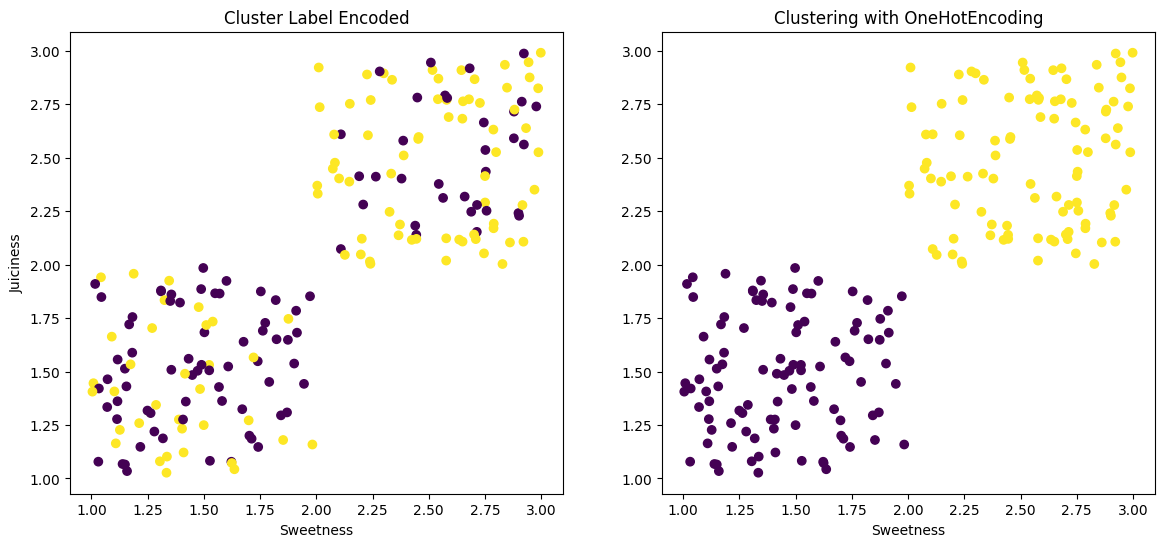

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# Generate synthetic data
n_samples = 100
sweet_juicy = np.random.uniform(2, 3, (n_samples, 2))
not_sweet_not_juicy = np.random.uniform(1, 2, (n_samples, 2))

# Assign colors (ordinal labels should coincide with the natural clusters)
colors_sweet_juicy = np.random.choice(['Blue', 'Orange', 'Purple'], n_samples)
colors_not_sweet_not_juicy = np.random.choice(['Green', 'Pink', 'Red'], n_samples)

# Combine data
X = np.vstack([sweet_juicy, not_sweet_not_juicy])
colors = np.concatenate([colors_sweet_juicy, colors_not_sweet_not_juicy])

# Create DataFrame
df = pd.DataFrame(X, columns=['Sweetness', 'Juiciness'])
df['Color'] = colors

# OneHotEncoding
# Note the "spare=False" - this is necessary because we are converting the encoded matrix
# back into a DataFrame
encoder = OneHotEncoder(sparse=False)

colors_one_hot = encoder.fit_transform(df[['Color']])
df_one_hot = pd.DataFrame(colors_one_hot, columns=encoder.get_feature_names_out(['Color']))

# Combine the original dataframe with one-hot-encoded dataframe
df_combined = pd.concat([df, df_one_hot], axis=1)

# Label encode (alphabetic)
le1 = LabelEncoder()
df['Color_auto_encoded'] = le1.fit_transform(df['Color'])

# Perform k-means clustering with auto-encoded labels
kmeans_auto = KMeans(n_clusters=2, random_state=0)
df['Cluster_auto_encoded'] = kmeans_auto.fit_predict(df[['Sweetness', 'Juiciness','Color_auto_encoded']])


# Performing k-means clustering with one-hot-encoded labels
kmeans_one_hot = KMeans(n_clusters=2, random_state=0)
df_combined['Cluster_one_hot_encoded'] = kmeans_one_hot.fit_predict(df_combined.drop(['Color'], axis=1))

# Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(df['Sweetness'], df['Juiciness'], c=df['Cluster_auto_encoded'], cmap='viridis')
axes[0].set_title('Cluster Label Encoded')
axes[0].set_xlabel('Sweetness')
axes[0].set_ylabel('Juiciness')


axes[1].scatter(df_combined['Sweetness'], df_combined['Juiciness'], c=df_combined['Cluster_one_hot_encoded'], cmap='viridis')
axes[1].set_title('Clustering with OneHotEncoding')
axes[1].set_xlabel('Sweetness')
axes[1].set_label('Juiciness')

plt.show()


Note the `sparse=False` in the above code.  Notice what happens if we don't do this.

In [4]:
X = [['red'], ['blue'], ['green']]

encoder_sparse = OneHotEncoder()
sparse_output = encoder_sparse.fit_transform(X)

pd.DataFrame(sparse_output,columns=encoder_sparse.get_feature_names_out(['Color']))

ValueError: Shape of passed values is (3, 1), indices imply (3, 3)

This is is because the OneHotEncoder returns a `sparse` matrix by default, which is a memory efficient format for matrices with lots of `0`s.  This cannot be directly converted to a pandas DataFrame with the desired shape, yielding a mismatch between the number of labels and the size of the DataFrame.

### Applying One-hot encoding to multiple columns

Although you can apply one-hot encoding on a column by column basis, it is often the case that you will have to apply it to multiple columns.  One way to do this is to loop through the columns you care about, and apply one-hot encoding to each in turn.  This would look like:

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assuming df is your DataFrame
# Initialize an empty DataFrame to hold the transformed columns
df_transformed = pd.DataFrame()

# Loop through each column in the original DataFrame
for col in df.columns:
    # Check if the column is of object or category type
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # Initialize the OneHotEncoder
        encoder = OneHotEncoder(sparse=False, drop='first')
        
        # Fit and transform the column and convert it to a DataFrame
        one_hot_encoded = encoder.fit_transform(df[[col]])
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out([col]))
        
        # Concatenate the one-hot-encoded DataFrame to the transformed DataFrame
        df_transformed = pd.concat([df_transformed, one_hot_df], axis=1)
    else:
        # If the column is not categorical, just copy it to the transformed DataFrame
        df_transformed[col] = df[col].copy()

/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/jeintron/Dropbox/@

### Example 

Try applying one-hot encoding using the above method to the following table:

In [ ]:
sample = pd.DataFrame({
    'color': ['red', 'blue', 'green', 'red', 'blue', 'green'],
    'target': ['apple', 'sky', 'grass', 'sky', 'moon', 'apple']
})

# Your code here


### Strategies for Imputing Missing Categorical Data

You might have realized that because OneHotEncoder fails with missing values, and SciKit learn prefers to work with numerical data, we face a bit of a conundrum when trying to deal with missing categorical values.  Note that we really don't want to use these imputers after a one-hot encoding either, because there is is no guarantee these imputers will follow the implicit rule that only one column of a one-hot encoded categorical set can be `1`. Here are two strategies.

#### Using Pandas or Most Frequent Category

You can use pandas to replace nulls, using one of the methods we covered previously. Alternatively, you can use SimpleImputer with the `strategy='most_frequent'` option to impute missing values with the most frequent category in each column before one-hot encoding.


In [ ]:
from sklearn.impute import SimpleImputer

# Create DataFrame with missing values
df = pd.DataFrame({
    'color': ['red', 'blue', np.nan, 'red', np.nan, 'green'],
    'target': [1, 0, 1, 0, 0, 1]
})

# Impute missing values
imp = SimpleImputer(strategy='most_frequent')
df['color'] = imp.fit_transform(df[['color']])[:,0]
df

,color,target
0,red,1
1,blue,0
2,red,1
3,red,0
4,red,0
5,green,1


#### Use a Different Library!

As you might imagine, others have struggled with this, and so there are other libraries designed to address this problem.  For instance, the `fancyimpute` package has both a KNNImputer and an IterativeImputer you might try.  Here's an example with the `KNNImputer` from `fancyimpute`.

In [ ]:
!pip install fancyimpute

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/ed/42/25b2cacd49a10547d36c530df400da1729511dbc8f5d725712130038cc65/cvxpy-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for cvxopt from https://files.pythonhosted.org/packages/c2/ab/78b8dcaf31f034184c4d9051562631856212614f34b9246f694dfb3e105b/cvxopt-1.3.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for pytest from https://files.pythonhosted.org/packages/df/d0/e192c4275aecabf74faa1aacd75ef700091913236ec78b1a98f62a2412ee/pytest-7.4.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 1.5 MB/s eta 0:00:0000:0100:01
  Obtaining de


#### FancyImputes K-Nearest Neighbors (KNN) Imputer

KNN from fancyimputer won't work with categorical data directly, but instead of using the `mean` (which is used by SciKit Learn's KNNImputer) is uses the `mode` for imputation, which is what we want.  To use KNN, first you should first encode your data using an `OrdinalEncoder` or `LabelEncoder`, then impute, then transform your data back into the categorical values you want.  This is more complicated than it should be because there is no easy way to preserve nulls in your data.



In [ ]:
import pandas as pd
import numpy as np
from fancyimpute import KNN
from sklearn.preprocessing import LabelEncoder

# Create DataFrame with missing values
data = {
    'Fruit': ['Apple', 'Banana', 'Cherry', 'Apple', None, 'Banana'],
    'Color': ['Red', 'Yellow', 'Red', None, 'Green', 'Yellow']
}

df = pd.DataFrame(data)

# Dictionary to hold LabelEncoders for each column
encoders = {}

# Replace categorical string values with numerical representations
for col in df.columns:
    le = LabelEncoder()
    not_null_mask = df[col].notnull()
    df.loc[not_null_mask, col] = le.fit_transform(df.loc[not_null_mask, col].astype(str))
    encoders[col] = le

# Use KNN to impute the missing values
knn_imputer = KNN()
df_imputed = knn_imputer.fit_transform(df)

# Round imputed values and convert to int for decoding
# Note that the rounding is necessary because NaNs force columns to become floats
df_imputed = pd.DataFrame(np.round(df_imputed), columns=df.columns).astype(int)

# Decode imputed values back to original categorical values
for col in df.columns:
    df_imputed[col] = encoders[col].inverse_transform(df_imputed[col])

print(df_imputed)

Imputing row 1/6 with 0 missing, elapsed time: 0.001
    Fruit   Color
0   Apple     Red
1  Banana  Yellow
2  Cherry     Red
3   Apple     Red
4  Banana   Green
5  Banana  Yellow


Other strategies may be applied in a similar manner, after which you can one-hot encode your data, and proceed with additional processing!

Note that there is currently no elegant solution for imputation of categorical variables, and so if you want something more sophisticated than a SimpleImputer with a "most_frequent" strategy, you'll probably need to write some code.  However, we can turn the above method into our own "Imputer" class like this:

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN
import pandas as pd
import numpy as np

class CategoricalKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, include_numeric=False, include_cols = []):
        self.encoders = {}
        self.knn_imputer = KNN()
        self.include_numeric = include_numeric
        self.include_cols = include_cols
    
    def fit(self, X, y=None):
        X = X.copy()
        
        if self.include_numeric:
            self.cols = X.columns.tolist()
        else:
            self.cols = X.select_dtypes(include=['object', 'category']).columns.tolist()+self.include_cols
            
        for col in self.cols:
            le = LabelEncoder()
            not_null_mask = X[col].notnull()
            if not_null_mask.sum() > 0:  # Only if there are non-null values to fit
                X.loc[not_null_mask, col] = le.fit_transform(X.loc[not_null_mask, col].astype(str))
                self.encoders[col] = le
        return self
    
    def transform(self, X):
        X_original = X.copy()
        X = X.copy()
        
        for col in self.cols:
            if col in self.encoders:  # Only if encoder exists
                not_null_mask = X[col].notnull()
                X.loc[not_null_mask, col] = self.encoders[col].transform(X.loc[not_null_mask, col].astype(str))
        
        X_imputed = self.knn_imputer.fit_transform(X)
        X_imputed = pd.DataFrame(X_imputed, columns=X.columns)
        
        for col in self.cols:
            if col in self.encoders:  # Only if encoder exists
                X_imputed.loc[:, col] = np.round(X_imputed.loc[:, col])  # Rounding only categorical columns
                X_imputed[col] = X_imputed[col].astype(int)  # Converting to int before decoding
                X_imputed[col] = self.encoders[col].inverse_transform(X_imputed[col])
        
        if not self.include_numeric:
            replacements = [x for x in X.columns if x not in self.cols]
            #numeric_cols = X_original.select_dtypes(include=[np.number]).columns
            X_imputed[replacements] = X_original[replacements]
        
        return X_imputed



The details of the Python might be more than you can understand at this point, but you should be able to recognize roughly what's going on here; we're simply building a component that works with SciKit Learn to do KNN based imputation on categorical columns.  You can apply this just like other SciKit Learn components, using `fit` and `transform`.



### Exercise

In along with this notebook, there is a data file called `synthetic_data_training.csv` which simulates a dataset of patients who have been examined for cardiovascular disease (CVD).  The data contains the following columns:

#### Columns:
1. **gender** (Categorical): Gender of the patient. (Male, Female)
2. **age** (Numeric): Age of the patient.
3. **bmi** (Numeric): Body Mass Index of the patient.
4. **systolic_bp** (Numeric): Systolic blood pressure level of the patient.
5. **diastolic_bp** (Numeric): Diastolic blood pressure level of the patient.
6. **cholesterol_level** (Numeric): Cholesterol level of the patient. 
7. **exercise_frequency** (Categorical): How often the patient exercises.
8. **smoker** (Categorical): Whether the patient is a smoker or not. (0=No, 1=Yes).
9. **family_history** (Categorical): Whether the patient has a family history of the disease. (0=No, 1=Yes).
10. **diet_quality** (Categorical): Quality of the patient's diet. 
11. **us_state** (Categorical): The US State where the patient resides.
12. **has_disease** (Binary): Whether the patient has the disease or not. (0=No, 1=Yes).

#### Task:
Impute missing values categorical and numeric columns, using several different methods:

- For BMI, use a KNN imputer (KNNImputer) and a SimpleImputer with a mean value
- For exercise frequency, use the CategoricalKNNImputer we defined above and a SimpleImputer with a "most_frequent" value.  

Compare histograms.  Which looks the best to you?

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

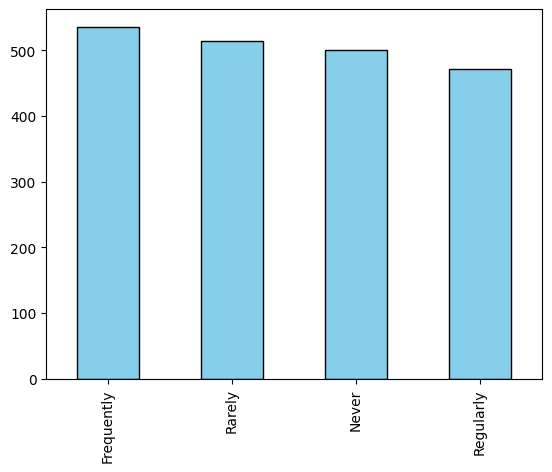

In [7]:
# Note: To examine distributions on categorical columns, you can simply use bar charts, like this
data = pd.read_csv("synthetic_data_training.csv")
exercise_frequency_counts = data.exercise_frequency.value_counts() 
exercise_frequency_counts.plot(kind='bar',color='skyblue', edgecolor='black')
plt.show()


### Imputing Numerical Data BMI column

In [8]:
## finding missing columns
def find_missing(df):
    # Find columns with missing values
    has_missing_values = df.columns[df.isnull().any()].tolist()

    # Print the columns with missing values
    print("Columns with Missing Values:")
    print(has_missing_values) 
    
find_missing(data)

Columns with Missing Values:
['bmi', 'systolic_bp', 'diastolic_bp', 'exercise_frequency', 'smoker', 'family_history', 'diet_quality', 'cholesterol_level']


#### Imputing

In [9]:
# Create a copy of the data for processing
data_processed = data.copy()

# these are the numerical columns with missing values
cols_to_impute = ['bmi', 'systolic_bp', 'diastolic_bp','family_history','smoker', 'cholesterol_level']

# Data to be imputed
imputation_data = data_processed[cols_to_impute]

# Create a KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# KNN imputation
imputed_data_knn = knn_imputer.fit_transform(imputation_data)

# Replace imputed data with KNN imputed data
data_processed[cols_to_impute] = imputed_data_knn

# Create a SimpleImputer for mean imputation
mean_imputer = SimpleImputer(strategy='mean')

# Mean imputation
imputed_data_mean = mean_imputer.fit_transform(imputation_data)

# Replace imputed data with mean imputed data
data_processed[cols_to_impute] = imputed_data_mean

# Display the first few rows of the processed data
data_processed.head()

,gender,age,bmi,systolic_bp,diastolic_bp,exercise_frequency,smoker,family_history,diet_quality,us_state,shoe_size,cholesterol_level,has_disease
0,Male,53,19.138668,121.898174,61.773357,NaN,1.0,1.000000,Poor,NY,12.365815,160.204426,0
1,Female,23,32.498117,154.821812,68.959128,Regularly,1.0,0.497027,Average,OH,10.585105,145.484203,0
2,Male,27,33.151563,185.758938,113.805127,Regularly,1.0,0.000000,NaN,FL,12.346710,206.106997,1
3,Female,32,37.248601,163.894943,57.066786,Frequently,0.0,1.000000,Poor,OH,7.997821,257.131324,1
4,Female,18,26.668744,117.623795,93.728305,NaN,0.0,0.000000,Good,NY,11.679335,249.370450,0


### Imputing Categorical Data

In [14]:
# get data
data_imputed = data_processed.copy()
cats_cols = ['exercise_frequency','diet_quality']
data_categorical = data_imputed[cats_cols]

# Uusing simple imputer
imputer = SimpleImputer(strategy='most_frequent')
data_categorical_imputed = pd.DataFrame(imputer.fit_transform(data_categorical), columns=cats_cols)

# create a class object
categorical_imputer = CategoricalKNNImputer()

# Fit the imputer on your categorical data
categorical_imputer.fit(data_categorical_imputed)

# transform using the supplied class
imputed_data_categorical = categorical_imputer.transform(data_categorical_imputed)

# replace the data
data_imputed[cats_cols] = imputed_data_categorical

# Ddisplay data
data_imputed.head()

c:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/2250 with 0 missing, elapsed time: 1.450
Imputing row 101/2250 with 0 missing, elapsed time: 1.452
Imputing row 201/2250 with 0 missing, elapsed time: 1.454
Imputing row 301/2250 with 0 missing, elapsed time: 1.457
Imputing row 401/2250 with 0 missing, elapsed time: 1.458
Imputing row 501/2250 with 0 missing, elapsed time: 1.492
Imputing row 601/2250 with 0 missing, elapsed time: 1.493
Imputing row 701/2250 with 0 missing, elapsed time: 1.495
Imputing row 801/2250 with 0 missing, elapsed time: 1.496
Imputing row 901/2250 with 0 missing, elapsed time: 1.498
Imputing row 1001/2250 with 0 missing, elapsed time: 1.499
Imputing row 1101/2250 with 0 missing, elapsed time: 1.501
Imputing row 1201/2250 with 0 missing, elapsed time: 1.502
Imputing row 1301/2250 with 0 missing, elapsed time: 1.505
Imputing row 1401/2250 with 0 missing, elapsed time: 1.507
Imputing row 1501/2250 with 0 missing, elapsed time: 1.508
Imputing row 1601/2250 with 0 missing, elapsed time: 1.510
Imputing 

,gender,age,bmi,systolic_bp,diastolic_bp,exercise_frequency,smoker,family_history,diet_quality,us_state,shoe_size,cholesterol_level,has_disease
0,Male,53,19.138668,121.898174,61.773357,Frequently,1.0,1.000000,Poor,NY,12.365815,160.204426,0
1,Female,23,32.498117,154.821812,68.959128,Regularly,1.0,0.497027,Average,OH,10.585105,145.484203,0
2,Male,27,33.151563,185.758938,113.805127,Regularly,1.0,0.000000,Poor,FL,12.346710,206.106997,1
3,Female,32,37.248601,163.894943,57.066786,Frequently,0.0,1.000000,Poor,OH,7.997821,257.131324,1
4,Female,18,26.668744,117.623795,93.728305,Frequently,0.0,0.000000,Good,NY,11.679335,249.370450,0


### Important Considerations

When training machine learning models with imputed data, it's crucial to follow best practices to ensure the robustness and generalizability of your models. Here’s a guide that covers considerations like data leakage, when to use imputed data, and other relevant aspects:

#### 1. Data Splitting
Always split your dataset into training, validation (optional), and test sets before any imputation to avoid data leakage. Leakage occurs when information from the validation/test sets is used to inform any part of the modeling process, leading to overly optimistic performance estimates.

```python
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
```

#### 2. Imputation
Perform imputation separately on each set:
   - Fit the imputer on the training set.
   - Transform both the training and test sets.

```python
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)  # Fit only on the training set

X_train_imputed = imputer.transform(X_train)  # Transform the training set
X_test_imputed = imputer.transform(X_test)  # Transform the test set
```

#### 3. When to Use Imputed Data
- When the amount of missing data is substantial, imputation can leverage the available information, which would otherwise be discarded if only complete cases are used.
- When the data are missing at random or missing completely at random, imputation can yield unbiased estimators.

#### 4. When to Avoid Imputed Data
- When missingness is related to the unobserved value itself (missing not at random), imputation might introduce bias.
- When there are very few observed cases, imputation might overfit the training data, and it's better to use complete cases if available.

#### 5. Model Evaluation
- Evaluate model performance on the test set with imputed values, focusing on metrics relevant to your specific problem.
- Consider performing sensitivity analyses by using different imputation methods and comparing the results.
- Additionally, assess the model's performance on only complete cases in the test set, to understand how much information is gained (or lost) due to imputation.

#### 6. Other Considerations
- **Hyperparameter Tuning and Model Selection:** Conduct model selection and hyperparameter tuning using only the training set. Use techniques like cross-validation to assess model generalization on the training set before final evaluation on the test set.
- **Complex Imputation Methods:** More advanced imputation methods like model-based imputation or multiple imputations may provide better results but come with their assumptions and computational cost.
- **Documentation:** Document all the steps involved in the imputation process, the reasons for choosing a particular imputation method, and any assumptions made.
